In [1]:
#import packages
#from isochrones.mist import MIST_Isochrone
#from isochrones import StarModel
from astropy.io import fits
import pickle
import numpy as np
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
from astropy.io import fits
import sys
import math
import os
import csv
from glob import glob
from scipy import interpolate
from scipy.interpolate import griddata
import warnings
warnings.filterwarnings('ignore')


#set plotting defaults to values that make plots look publication ready
cmap = plt.cm.Spectral # color scheme -- visible color spectrum, starting with red as the earliest
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['font.size'] = 14
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 4
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'

# Access Gaia+APOGEE DR14 cross match 

In [2]:
matchedfile = 'allstar_HugeTable.fits'
giant_catalog = fits.open(matchedfile)

# Use gaia parallaxes to calculate distance moduli and absolute K magnitudes for each source. Construct J-K vs. M_K color-mag diagram for APOGEE+Gaia(+2MASS) sample, then filter using different parallax/sigma combos

In [3]:
#read in magnitudes and distance modulii
J_app = giant_catalog[1].data['J']
H_app = giant_catalog[1].data['H']
K_app = giant_catalog[1].data['K']
RP_app = giant_catalog[1].data['phot_rp_mean_mag']
BP_app = giant_catalog[1].data['phot_bp_mean_mag']
G_app = giant_catalog[1].data['phot_g_mean_mag']
J_app_err = giant_catalog[1].data['J_ERR']
H_app_err = giant_catalog[1].data['H_ERR']
K_app_err = giant_catalog[1].data['K_ERR']
DistMod = giant_catalog[1].data['DistMod']
parallax = giant_catalog[1].data['parallax']
J_minus_K = J_app - K_app

#compute the absolute mags
J_abs = J_app + DistMod
K_abs = K_app + DistMod
H_abs = H_app + DistMod

#error analysis, https://en.wikipedia.org/wiki/Propagation_of_uncertainty
parallax_error = giant_catalog[1].data['parallax_error']
parallax_error_percent = parallax_error/parallax
Distance = 1 / giant_catalog[1].data['Parallax'] 
Distance_err = parallax_error_percent*Distance
DistMod_err = 5 * Distance_err / (Distance * np.log(10))
J_minus_K_err = (J_app_err**2 + K_app_err**2)**(1/2)
K_abs_err = (DistMod_err**2 + K_app_err**2)**(1/2)

#find stars that lie within an acceptable range of colors and mags
realistic = np.where( (J_app - K_app > -1) & (J_app - K_app < 4) & (K_app + DistMod > -10) & (K_app + DistMod < 10) )

[-0.25, 2, 10, -10]

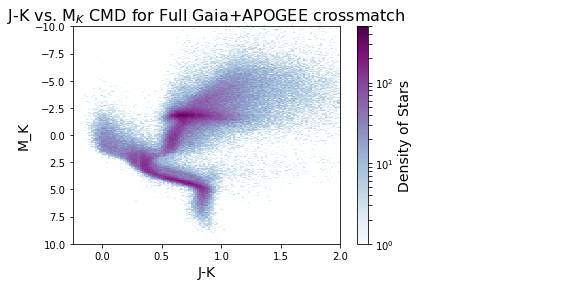

In [4]:
#use the hist2d command to show the density of APOGEE+Gaia stars in the J-K vs. M_K ColorMagnitude Diagram.
JK_CMD = plt.hist2d(J_app[realistic] - K_app[realistic], K_app[realistic] + DistMod[realistic], 
           bins=(250,250), cmap=plt.cm.BuPu, norm=clrs.LogNorm(vmin=(1), vmax=(500)))
plt.colorbar(label = 'Density of Stars')
plt.title('J-K vs. M$_{K}$ CMD for Full Gaia+APOGEE crossmatch' )
xlabel = plt.xlabel('J-K') 
ylabel = plt.ylabel('M_K')
plt.axis([-0.25,2,10,-10])

#plt.savefig('Gaia+APOGEE_J-KvsK_CMD.jpg', bbox_inches='tight')

In [5]:
#include a restriction on the quality of the parallax detection
parallax = giant_catalog[1].data['parallax']
parallax_error = giant_catalog[1].data['parallax_error']

tenSigmaParallax = np.where( ( (parallax / parallax_error) > 10) & (J_app - K_app > -1) & (J_app - K_app < 4) & (K_app + DistMod > -10) & (K_app + DistMod < 10) )

[-0.25, 2, 10, -10]

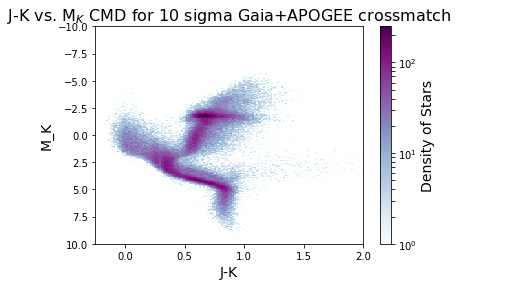

In [6]:
#use the hist2d command to show the density of APOGEE+Gaia stars in the J-K vs. M_K ColorMagnitude Diagram.
JK_CMD = plt.hist2d(J_app[tenSigmaParallax] - K_app[tenSigmaParallax], K_app[tenSigmaParallax] + DistMod[tenSigmaParallax], 
           bins=(250,250), cmap=plt.cm.BuPu, norm=clrs.LogNorm(vmin=(1), vmax=(250)))
plt.colorbar(label = 'Density of Stars')
plt.title('J-K vs. M$_{K}$ CMD for 10 sigma Gaia+APOGEE crossmatch' )
xlabel = plt.xlabel('J-K') 
ylabel = plt.ylabel('M_K')
plt.axis([-0.25,2,10,-10])

#plt.savefig('Gaia+APOGEE_J-KvsK_CMD_10Sigma.jpg', bbox_inches='tight') 

[-0.25, 2, 10, -10]

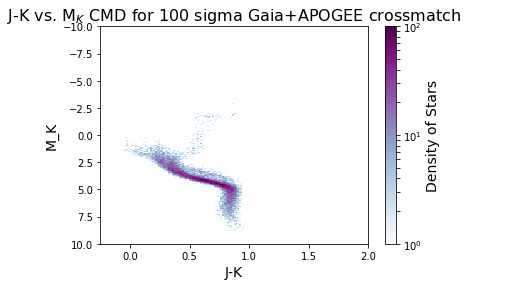

In [7]:
#finally, restrict to 100 sigma parallax detections
hundredSigmaParallax = np.where( ( (parallax / parallax_error) > 100) & (J_app - K_app > -1) & (J_app - K_app < 4) & (K_app + DistMod > -10) & (K_app + DistMod < 10) )

#use the hist2d command to show the density of APOGEE+Gaia stars in the J-K vs. M_K ColorMagnitude Diagram.
JK_CMD = plt.hist2d(J_app[hundredSigmaParallax] - K_app[hundredSigmaParallax], K_app[hundredSigmaParallax] + DistMod[hundredSigmaParallax], 
           bins=(250,250), cmap=plt.cm.BuPu, norm=clrs.LogNorm(vmin=(1), vmax=(100)))
plt.colorbar(label = 'Density of Stars')
plt.title('J-K vs. M$_{K}$ CMD for 100 sigma Gaia+APOGEE crossmatch' )
xlabel = plt.xlabel('J-K') 
ylabel = plt.ylabel('M_K')
plt.axis([-0.25,2,10,-10])

#plt.savefig('Gaia+APOGEE_J-KvsK_CMD_100Sigma.jpg', bbox_inches='tight') 

# Handling Main Sequence Stars

# Filter young cluster plates OUT of the main sequence sample

In [12]:
# Getting the field (region) indices
One91_12 = np.where(giant_catalog[1].data['field']=='191-12')
K2_C4_168_21 = np.where(giant_catalog[1].data['field']=='K2_C4_168-21')
TWO03PLUS04 = np.where(giant_catalog[1].data['field']=='203+04')
IC348 = np.where(giant_catalog[1].data['field']=='IC348')
LAMBDAORI_A = np.where(giant_catalog[1].data['field']=='LAMBDAORI-A')
LAMBDAORI_B = np.where(giant_catalog[1].data['field']=='LAMBDAORI-B')
N1333 = np.where(giant_catalog[1].data['field']=='N1333')
ORIONA = np.where(giant_catalog[1].data['field']=='ORIONA')
ORIONB = np.where(giant_catalog[1].data['field']=='ORIONB')
ORIONB_A = np.where(giant_catalog[1].data['field']=='ORIONB-A')
ORIONB_B = np.where(giant_catalog[1].data['field']=='ORIONB-B')
ORIONC = np.where(giant_catalog[1].data['field']=='ORIONC')
ORIOND = np.where(giant_catalog[1].data['field']=='ORIOND')
ORIONE = np.where(giant_catalog[1].data['field']=='ORIONE')
ORIONOB1AB_F = np.where(giant_catalog[1].data['field']=='ORIONOB1AB-F')
PLEIADES_E = np.where(giant_catalog[1].data['field']=='PLEIADES-E')
Pleiades = np.where(giant_catalog[1].data['field']=='Pleiades')

In [13]:
# The indices of MS and Pre-MS stars 
All_Indices = np.where(giant_catalog[1].data['field'])
PMS_Indices = np.unique(np.concatenate([One91_12,  K2_C4_168_21,  TWO03PLUS04,  
                IC348,  LAMBDAORI_A,  LAMBDAORI_B,  N1333,  ORIONA,  ORIONB,  
                ORIONB_A,  ORIONB_B,  ORIONC,  ORIOND,  ORIONE,  ORIONOB1AB_F,
                PLEIADES_E,  Pleiades], axis = 1))
MS_Indices = np.setdiff1d(All_Indices,PMS_Indices)

print("Double checking that this indexing works, this should equal zero")
print('ALL - PMS - MS: ', np.size(All_Indices)-(np.size(PMS_Indices)+np.size(MS_Indices)))

Double checking that this indexing works, this should equal zero
ALL - PMS - MS:  0


In [29]:
#read in magnitudes and distance modulii
J_app = giant_catalog[1].data['J']
H_app = giant_catalog[1].data['H']
K_app = giant_catalog[1].data['K']
J_app_err = giant_catalog[1].data['J_ERR']
H_app_err = giant_catalog[1].data['H_ERR']
K_app_err = giant_catalog[1].data['K_ERR']
DistMod = giant_catalog[1].data['DistMod']
parallax = giant_catalog[1].data['parallax']
J_minus_K = J_app - K_app
g = giant_catalog[1].data['gmag_pan']
r = giant_catalog[1].data['rmag_pan']
ra_APOGEE = giant_catalog[1].data['ra_APOGEE']
dec_APOGEE = giant_catalog[1].data['dec_APOGEE']
AP_IDS = giant_catalog[1].data['APOGEE_ID']
Source_IDS = giant_catalog[1].data['source_id']
#compute the absolute mags
J_abs = J_app + DistMod
K_abs = K_app + DistMod
H_abs = H_app + DistMod

#error analysis, https://en.wikipedia.org/wiki/Propagation_of_uncertainty
parallax_error = giant_catalog[1].data['parallax_error']
parallax_error_percent = parallax_error/parallax
Distance = 1 / giant_catalog[1].data['Parallax']
Distance_err = parallax_error_percent*Distance
DistMod_err = 5 * Distance_err / (Distance * np.log(10))
J_minus_K_err = (J_app_err**2 + K_app_err**2)**(1/2)
K_abs_err = (DistMod_err**2 + K_app_err**2)**(1/2)





In [15]:
#filtering the batch of MS stars
J_app_MS = J_app[MS_Indices]
H_app_MS = H_app[MS_Indices]
K_app_MS = K_app[MS_Indices]
J_abs_MS = J_abs[MS_Indices]
K_abs_MS = K_abs[MS_Indices]
H_abs_MS = H_abs[MS_Indices]
g_MS = g[MS_Indices]
r_MS = r[MS_Indices]
DistMod_MS = DistMod[MS_Indices]
parallax_MS = parallax[MS_Indices]
ra_APOGEE_MS = ra_APOGEE[MS_Indices]
dec_APOGEE_MS = dec_APOGEE[MS_Indices]
AP_IDS_MS = AP_IDS[MS_Indices]
Source_IDS_MS = Source_IDS[MS_Indices]
parallax_error_MS = parallax_error[MS_Indices]
parallax_error_percent_MS = parallax_error_percent[MS_Indices]
Distance_MS = Distance[MS_Indices]
Distance_err_MS = Distance_err[MS_Indices]
DistMod_err_MS = DistMod_err[MS_Indices]
J_minus_K_err_MS =  J_minus_K_err[MS_Indices]
K_abs_err_MS = K_abs_err[MS_Indices]
J_minus_K_MS = J_minus_K[MS_Indices]

In [25]:
#Every equation used in the next cell has calibration bounds, set here
t_eff_bounds = np.where((0.7 < (J_app_MS-K_app_MS))   &  ((J_app_MS-K_app_MS) < 1.05)&  (3.37 < (g_MS-K_app_MS))   &  ((g_MS-K_app_MS)<8.46))
mass_bounds = np.where((K_abs_MS<10) & (K_abs_MS>5))
finite_bounds = np.where(np.isfinite(g_MS) & np.isfinite(r_MS))
calibration_index = np.intersect1d(np.intersect1d(t_eff_bounds, mass_bounds), finite_bounds)


J_app_MS = J_app_MS[calibration_index]
H_app_MS = H_app_MS[calibration_index]
K_app_MS = K_app_MS[calibration_index]
J_abs_MS = J_abs_MS[calibration_index]
K_abs_MS = K_abs_MS[calibration_index]
H_abs_MS = H_abs_MS[calibration_index]
g_MS = g_MS[calibration_index]
r_MS = r_MS[calibration_index]
DistMod_MS = DistMod_MS[calibration_index]
parallax_MS = parallax_MS[calibration_index]
ra_APOGEE_MS = ra_APOGEE_MS[calibration_index]
dec_APOGEE_MS = dec_APOGEE_MS[calibration_index]
AP_IDS_MS = AP_IDS_MS[calibration_index]
Source_IDS_MS = Source_IDS_MS[calibration_index]
Distance_MS = Distance_MS[calibration_index]

# Generate Fe_H, Mass, T_eff, and surface gravity for Main-Sequence Stars

In [17]:
# Inferring metallicity from photometry. Eqn 1, page 8 from https://arxiv.org/pdf/1502.07460.pdf
C1 = np.array([-14.2959, 0.0519, 29.5926, -0.0529, -17.6762, 0.7032])
Fe_H = C1[0] + C1[1]*(g_MS-K_app_MS) + C1[2]*(J_app_MS-K_app_MS) + (C1[3] * (g_MS-K_app_MS)**2) + (C1[4] * (J_app_MS-K_app_MS)**2) + C1[5] * (g_MS-K_app_MS) * (J_app_MS-K_app_MS)


#Inferring mass in units of solar mass from M_K. Eqn 11, page 26 of https://arxiv.org/pdf/1608.04775.pdf
C2 = np.array([.2311, -.1352, .0400, .0038, -.0032])
x = 7.5
Mass = C2[0] + C2[1]*(K_abs_MS-x) + C2[2]*(K_abs_MS-x)**2 + C2[3]*(K_abs_MS-x)**3 + C2[4]*(K_abs_MS-x)**4


# Determining Teff. Eqns 6 and 7, page 11, from https://arxiv.org/pdf/1501.01635.pdf
C3 = np.array([2.532, -1.319, 0.4449, -.07151, 0.004333, 0.05629])
x = r_MS - J_app_MS
T_eff = 3500 * (C3[0] + C3[1]*x + C3[2]*x**2 + C3[3]*x**3 + C3[4]*x**4 + C3[5]*(Fe_H))

x2 = r_MS - J_app_MS
C4 = np.array([2.151, -1.092,0.3767, -0.06292, 0.003950, 0.1697, 0.03106])
#T_eff2 = 3500 * (C4[0] + C4[1]*x2 + C4[2]*x2**2 + C4[3]*x2**3 + C4[4]*x2**4 + C4[5]*(J_app_MS-H_app_MS) + C4[6]*(J_app_MS-H_app_MS)**2)


#Using Teff and [Fe/H] to assign log g to stars. Eqn 5, page 7 from https://arxiv.org/pdf/1710.10259.pdf
log_g = 7.912 - 0.1880 * Fe_H - 1.335e-3 * T_eff + 1.313e-7 * ( T_eff ** 2 )
#log_g2 = 7.912 - 0.1880 * Fe_H - 1.335e-3 * T_eff2 + 1.313e-7 * ( T_eff2 ** 2 )

#  Check for consistency

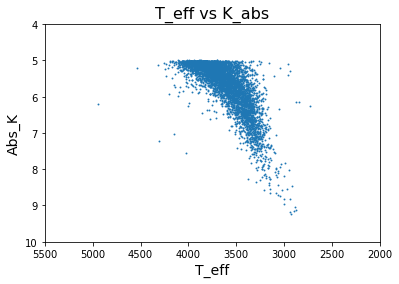

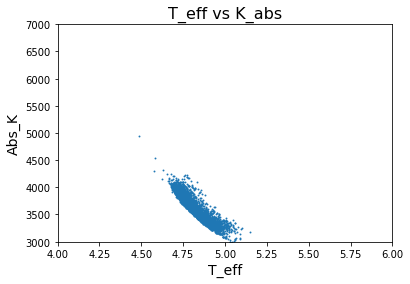

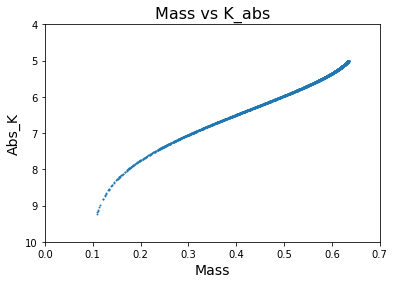

In [24]:
plt.figure()
plt.title("T_eff vs K_abs")
plt.ylabel("Abs_K")
plt.xlabel("T_eff")
plt.xlim(5500,2000)
plt.ylim(10,4)
plt.scatter(T_eff, K_abs_MS, s = 0.8)
plt.show()
#fit isochrones


plt.figure()
plt.title("T_eff vs K_abs")
plt.ylabel("Abs_K")
plt.xlabel("T_eff")
plt.xlim(4,6)
plt.ylim(3000,7000)
plt.scatter(log_g, T_eff, s = 0.8)
plt.show()
#fit isochrones


plt.figure()
plt.title("Mass vs K_abs")
plt.ylabel("Abs_K")
plt.xlabel("Mass")
plt.xlim(0,.7)
plt.ylim(10,4)
plt.scatter(Mass,K_abs_MS, s = 0.8)
plt.show()

# Plot Generation for the paper

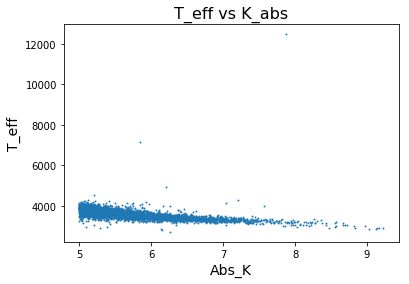

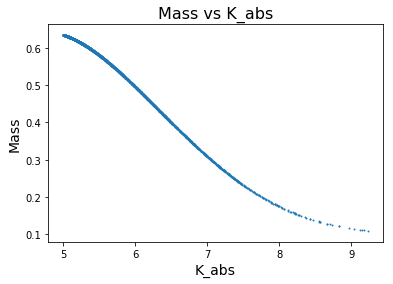

[0.66167122 0.1822732  0.38532537 ... 1.42011478 1.61059788 1.62222362]
[0.66167321 0.18227729 0.38535302 ... 1.42056399 1.61104073 1.62261522]


ValueError: cannot convert float NaN to integer

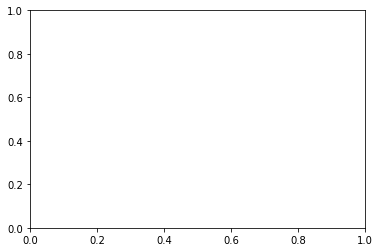

In [38]:
plt.figure()
plt.title("T_eff vs K_abs")
plt.ylabel("T_eff")
plt.xlabel("Abs_K")
#plt.xlim(5500,2000)
#plt.ylim(10,4)
plt.scatter(K_abs_MS, T_eff, s = 0.8)
plt.show()


plt.figure()
plt.title("Mass vs K_abs")
plt.xlabel("K_abs")
plt.ylabel("Mass")
#plt.xlim(4,6)
#plt.ylim(3000,7000)
plt.scatter(K_abs_MS, Mass, s = 0.8)
plt.show()



ra_APOGEE_MS
dec_APOGEE_MS
Distance_MS
horizontal_distance = np.cos( (2 * np.pi * dec_APOGEE_MS) / 360 ) * Distance_MS
z = np.sin( (2 * np.pi * dec_APOGEE_MS) / 360 ) * Distance_MS
x = np.cos( (2 * np.pi * ra_APOGEE_MS) / 360 ) * horizontal_distance
y = np.sin( (2 * np.pi * ra_APOGEE_MS) / 360 ) * horizontal_distance

print(x)
print(horizontal_distance)

plt.hist2d(x,y, bins=(250,250), cmap=plt.cm.BuPu, norm=clrs.LogNorm(vmin=(1), vmax=(500)))
plt.colorbar(label = 'Fe_H')
plt.title('Galactic Location and Metallicity' )
plt.xlabel('x-position') 
plt.ylabel('y-position')
plt.axis([-0.25,2,10,-10])


plt.figure()
plt.title("Mass vs K_abs")
plt.ylabel("Abs_K")
plt.xlabel("Mass")
plt.xlim(0,.7)
plt.ylim(10,4)
plt.scatter(Mass,K_abs_MS, s = 0.8)
plt.show()

In [16]:
#ranges of our values
print("Min max of Fe_H:", min(Fe_H), ",", max(Fe_H))
print("Min max of Mass:", min(Mass), ",", max(Mass))
print("Min max of T_eff:", min(T_eff), ",", max(T_eff))
print("Min max of log_g:", min(log_g), ",", max(log_g))

Min max of Fe_H: -0.9808347 , 0.318398
Min max of Mass: 0.10804131490110201 , 0.6347170651933377
Min max of T_eff: 2731.0208 , 12477.663
Min max of log_g: 4.489062 , 11.660149


In [22]:
#send labels that we already have to marina: http://docs.astropy.org/en/stable/io/fits/
col1 = fits.Column(name='ap_id', format='20A', array=AP_IDS_MS)
col2 = fits.Column(name='source_id', format='20A', array=Source_IDS_MS)
col3 = fits.Column(name='Fe_H', format='E', array=Fe_H)
col4 = fits.Column(name='Mass', format='E', array=Mass)
col5 = fits.Column(name='T_eff', format='E', array=T_eff)
col7 = fits.Column(name='log_g', format='E', array=log_g)
col9 = fits.Column(name='J_app', format='E', array=J_app_MS)
col10 = fits.Column(name='K_app', format='E', array=K_app_MS)
col11 = fits.Column(name='H_app', format='E', array=H_app_MS)
col12 = fits.Column(name='J_abs', format='E', array=J_abs_MS)
col13 = fits.Column(name='K_abs', format='E', array=K_abs_MS)
col14 = fits.Column(name='H_abs', format='E', array=H_abs_MS)
col15 = fits.Column(name='g', format='E', array=g_MS)
col16 = fits.Column(name='r', format='E', array=r_MS)
col17 = fits.Column(name='DistMod', format='E', array=DistMod_MS)
col18 = fits.Column(name='parallax', format='E', array=parallax_MS)
col19 = fits.Column(name='ra_APOGEE', format='E', array=ra_APOGEE_MS)
col20 = fits.Column(name='dec_APOGEE', format='E', array=dec_APOGEE_MS)


cols = fits.ColDefs([col1, col2, col3, col4, col5, col7,col9, col10, col11, col12, col13, col14, col15, col16,col17, col18, col19, col20])
hdu_export = fits.BinTableHDU.from_columns(cols)
hdu_export.writeto('MS_Labels_May_29_2019.fits')

In [15]:
#Sending the MS labels to Chad

#pulling data that we already have from the fits file
vmic = giant_catalog[1].data['VMICRO'][MS_Indices]
vmic = vmic[calibration_index]
vmac = giant_catalog[1].data['VMACRO'][MS_Indices]
vmac = vmac[calibration_index]


#matching the order of the payne labels file, 25 columns
AP_IDS_export = AP_IDS_MS
ra_APOGEE_export = ra_APOGEE_MS
dec_APOGEE_export = dec_APOGEE_MS
T_eff_export = T_eff
log_g_export = log_g
vmic_export = vmic
CH_export = np.zeros(np.size(calibration_index))
NH_export = np.zeros(np.size(calibration_index))
OH_export = np.zeros(np.size(calibration_index))
MgH_export = np.zeros(np.size(calibration_index))
AlH_export = np.zeros(np.size(calibration_index))
SiH_export = np.zeros(np.size(calibration_index))
SH_export = np.zeros(np.size(calibration_index))
KH_export = np.zeros(np.size(calibration_index))
CaH_export = np.zeros(np.size(calibration_index))
TiH_export = np.zeros(np.size(calibration_index))
CrH_export = np.zeros(np.size(calibration_index))
MnH_export = np.zeros(np.size(calibration_index))
FeH_export = Fe_H
Nih_export = np.zeros(np.size(calibration_index))
CuH_export = np.zeros(np.size(calibration_index))
C12C13_export = np.zeros(np.size(calibration_index))
vmac_export = vmac
chi2_export = np.zeros(np.size(calibration_index))
quality_flag_export = np.repeat("DNE", np.size(calibration_index))
total_export = np.c_[AP_IDS_export, ra_APOGEE_export, dec_APOGEE_export, T_eff_export,log_g_export,
                    vmic_export, CH_export, NH_export,OH_export,MgH_export,
                     AlH_export,SiH_export, SH_export,KH_export,CaH_export,
                     TiH_export,CrH_export,MnH_export,FeH_export,Nih_export,
                     CuH_export,C12C13_export,vmac_export,chi2_export,quality_flag_export]

#fmt = '%20s %10s %10s %8s %3s %3s %3s %s %s %s %20s %20s %20s %20s %20s %20s %20s %20s %20s %20s %20s %20s %20s %20s %20s'
fmt = "%s"
header = "# APOGEE_ID RA[deg] Dec[deg] Teff[K] Logg vmic[km/s] CH NH OH MgH AlH SiH SH KH CaH TiH CrH MnH FeH NiH CuH C12C13 vmac[km/s] chi2_R quality_flag"
np.savetxt('MS_labels.txt', total_export ,header = header, delimiter='   ', fmt=fmt) 

# Working on the Pre-Main_Sequnce Stars
# This process failed and we decided to use machine learning to generate the labels instead, everything below this cell can be considered a graveyard

# Using PreMS indices, and additional filter to remove non-members from the sample

In [17]:
#Using Dr. Kounkel's list to further filter down PMS stars.
member_file = open('ysos.txt', 'r')
members = np.array(member_file.read().split('\n'))
PMS_IDs = giant_catalog[1].data['APOGEE_ID'][PMS_Indices]
member_overlap = np.array(list((set(members) & set(PMS_IDs))))



#From the already sifted data, apply the member_index.
member_index_file = open('member_index.txt', 'r')
member_index = (np.array(member_index_file.read().split('\n'))[:-1]).astype(int)

# Filtering out the stars with disk excess

In [18]:
AP_IDS_PMSM = PMS_IDs[member_index]


disk_file = open('disks.txt', 'r')
disk_list = []
for line in disk_file:
    line = line.rstrip('\n')
    disk_list.append(line)
disk_list = np.array(disk_list)
disk_overlap = np.array(list((set(disk_list) & set(AP_IDS_PMSM))))




#Using this to get a memeber_index
export = []
for counter1,value1 in enumerate(disk_overlap):  
    for counter2, value2 in enumerate(AP_IDS_PMSM):
        if value2 == value1:
            export.append(counter2)
            
np.savetxt('disk_index.txt', export, fmt='%i', delimiter=',')   # X is an array

In [19]:
disk_index_file = open('disk_index.txt', 'r')
disk_index = (np.array(disk_index_file.read().split('\n'))[:-1]).astype(int)

non_disk_index = np.zeros(AP_IDS_PMSM.shape,dtype=bool)
non_disk_index[disk_index] = True

# Get the Pre-MS labels using MIST isochrones for pre-MS stars.

In [21]:
def apply_indices(array):
    array1 = array[PMS_Indices]
    array2 = array1[member_index]
    return array2[non_disk_index]

ap_ID = apply_indices(giant_catalog[1].data['APOGEE_ID'])
temp_PMSMD = apply_indices(giant_catalog[1].data['teff_val'])
temp_err_PMSMD = apply_indices( (giant_catalog[1].data['teff_percentile_upper']-giant_catalog[1].data['teff_percentile_lower'])/2 )
Dist_mod_PMSMD = apply_indices(giant_catalog[1].data['DistMod'])
K_app_PMSMD = apply_indices(giant_catalog[1].data['K'])
K_app_err_PMSMD = apply_indices(giant_catalog[1].data['K_ERR'])
J_app_PMSMD = apply_indices(giant_catalog[1].data['J'])
J_app_err_PMSMD = apply_indices(giant_catalog[1].data['J_ERR'])
H_app_PMSMD = apply_indices(giant_catalog[1].data['H'])
H_app_err_PMSMD = apply_indices(giant_catalog[1].data['H_ERR'])
RP_app_PMSMD = apply_indices(giant_catalog[1].data['phot_rp_mean_mag'])
RP_app_err_PMSMD = apply_indices(2.5*np.log10(giant_catalog[1].data['phot_rp_mean_flux']+giant_catalog[1].data['phot_rp_mean_flux_error'])-2.5*np.log10(giant_catalog[1].data['phot_rp_mean_flux']))
BP_app_PMSMD = apply_indices(giant_catalog[1].data['phot_bp_mean_mag'])
BP_app_err_PMSMD=apply_indices(2.5*np.log10(giant_catalog[1].data['phot_bp_mean_flux']+giant_catalog[1].data['phot_bp_mean_flux_error'])-2.5*np.log10(giant_catalog[1].data['phot_bp_mean_flux']))
G_app_PMSMD = apply_indices(giant_catalog[1].data['phot_g_mean_mag'])
G_app_err_PMSMD=apply_indices(2.5*np.log10(giant_catalog[1].data['phot_g_mean_flux']+giant_catalog[1].data['phot_g_mean_flux_error'])-2.5*np.log10(giant_catalog[1].data['phot_g_mean_flux']))
parallax_PMSMD = apply_indices(giant_catalog[1].data['parallax'])
parallax_error_PMSMD = apply_indices(giant_catalog[1].data['parallax_error'])
parallax_error_percent_PMSMD = apply_indices(parallax_error/parallax)

In [66]:
#matchedfile = 'GaiaAPOGEE_HugeTable_wDistMod.fits'
file = 'pms_lumteff.fits'
lum_teff_catalog = fits.open(file)
data = lum_teff_catalog[1].data

ids = data['OBJID']
para_ids = []
gaia_temps = []
gaia_temps_err = []

for id_ in ids:
    try:
        index = np.where(ap_ID == id_)[0][0]
        para_ids.append(index)
        gaia_temps.append(temp_PMSMD[index])
        gaia_temps_err.append(temp_err_PMSMD[index])
    except:
        print("ERRROORRRR")


lum_teff_catalog[1].header
data=lum_teff_catalog[1].data



teff= gaia_temps #data['teffmed']
teffe= gaia_temps_err #data['teffemed']
logL=np.log10((data['lum_percentile_upper']+data['lum_percentile_lower'])/2)
logLe=(np.log10(data['lum_percentile_upper'])-np.log10(data['lum_percentile_lower']))/2
p=parallax_PMSMD[para_ids]
pe=parallax_error_PMSMD[para_ids]
r=(data['radius_percentile_upper']+data['radius_percentile_lower'])/2
re=(data['radius_percentile_upper']-data['radius_percentile_lower'])/2



J = J_app_PMSMD[para_ids]
J_err = J_app_err_PMSMD[para_ids]
H = H_app_PMSMD[para_ids]
H_err = H_app_err_PMSMD[para_ids]
K = K_app_PMSMD[para_ids]
K_err = K_app_err_PMSMD[para_ids]
G = G_app_PMSMD[para_ids]
G_err = G_app_err_PMSMD[para_ids]
RP = RP_app_PMSMD[para_ids]
RP_err = RP_app_err_PMSMD[para_ids]
BP = BP_app_PMSMD[para_ids]
BP_err = BP_app_err_PMSMD[para_ids]
ap_ID = ap_ID[para_ids]

In [67]:
print(np.size(ap_ID))

611


# Generating the labels (mass and age)

In [50]:
mags={}

for i in range(611):
    print("Starting iteration ", i)
    
    if np.isfinite(p[i]): mags['parallax']=(p[i] , pe[i])
    if np.isfinite(teff[i]): mags['Teff']=(teff[i] , teffe[i])
    if np.isfinite(logL[i]): mags['logL']=(logL[i] , logLe[i])
    if np.isfinite(r[i]): mags['radius']=(r[i] , re[i])
    if np.isfinite(J[i]): mags['J']=(J[i] , J_err[i])
    if np.isfinite(H[i]): mags['H']=(H[i] , H_err[i])
    if np.isfinite(K[i]): mags['K']=(K[i] , K_err[i])
    if np.isfinite(G[i]): mags['G']=(G[i] , G_err[i])
    if np.isfinite(RP[i]): mags['RP']=(RP[i] , RP_err[i])
    if np.isfinite(BP[i]): mags['BP']=(BP[i] , BP_err[i])
        
    mags['feh']=(0 , .05)
    
    #if not '/cluster/home/kounkem/ages/'+str(i)+'.fits' in path:
    mist = MIST_Isochrone()
    mod = StarModel(mist, **mags)
    mod.set_bounds(age=(5,7.5),AV=(0,20))
    mod.fit(refit=True)


    mass=mod.samples.mass_0_0.quantile([0.045,0.317,0.5,0.682,0.954]).values
    rad=mod.samples.radius_0_0.quantile([0.045,0.317,0.5,0.682,0.954]).values
    feh=mod.samples.feh_0.quantile([0.045,0.317,0.5,0.682,0.954]).values
    age=mod.samples.age_0.quantile([0.045,0.317,0.5,0.682,0.954]).values
    dist=mod.samples.distance_0.quantile([0.045,0.317,0.5,0.682,0.954]).values
    av=mod.samples.AV_0.quantile([0.045,0.317,0.5,0.682,0.954]).values
    
    from astropy.table import Table
    largearr=np.zeros((5,6),dtype=np.dtype('a25'))
    largearr[:,0]=mass
    largearr[:,1]=rad
    largearr[:,2]=feh
    largearr[:,3]=age
    largearr[:,4]=dist
    largearr[:,5]=av

    print("Writing in iteration ", i)

    names=['mass','rad','feh','age','dist','av']
    fmt=['f','f','f','f','f','f']
    t = Table(largearr, names=names, meta={'keywords': {'key1': 'val1'}},dtype=fmt)
    try:
        t.write('pre_MS_teff_lum_6_colors_feh_0/star_'+str(i)+'.fits')
    except:
        os.remove('pre_MS_teff_lum_6_colors_feh_0/star_'+str(i)+'.fits')
        t.write('pre_MS_teff_lum_6_colors_feh_0/star_'+str(i)+'.fits')


Starting iteration  0
Writing in iteration  0
Starting iteration  1
Writing in iteration  1
Starting iteration  2
Writing in iteration  2
Starting iteration  3
Writing in iteration  3
Starting iteration  4
Writing in iteration  4
Starting iteration  5
Writing in iteration  5
Starting iteration  6
Writing in iteration  6
Starting iteration  7
Writing in iteration  7
Starting iteration  8
Writing in iteration  8
Starting iteration  9
Writing in iteration  9
Starting iteration  10
Writing in iteration  10
Starting iteration  11
Writing in iteration  11
Starting iteration  12
Writing in iteration  12
Starting iteration  13
Writing in iteration  13
Starting iteration  14
Writing in iteration  14
Starting iteration  15
Writing in iteration  15
Starting iteration  16
Writing in iteration  16
Starting iteration  17
Writing in iteration  17
Starting iteration  18
Writing in iteration  18
Starting iteration  19
Writing in iteration  19
Starting iteration  20
Writing in iteration  20
Starting ite

Writing in iteration  168
Starting iteration  169
Writing in iteration  169
Starting iteration  170
Writing in iteration  170
Starting iteration  171
Writing in iteration  171
Starting iteration  172
Writing in iteration  172
Starting iteration  173
Writing in iteration  173
Starting iteration  174
Writing in iteration  174
Starting iteration  175
Writing in iteration  175
Starting iteration  176
Writing in iteration  176
Starting iteration  177
Writing in iteration  177
Starting iteration  178
Writing in iteration  178
Starting iteration  179
Writing in iteration  179
Starting iteration  180
Writing in iteration  180
Starting iteration  181
Writing in iteration  181
Starting iteration  182
Writing in iteration  182
Starting iteration  183
Writing in iteration  183
Starting iteration  184
Writing in iteration  184
Starting iteration  185
Writing in iteration  185
Starting iteration  186
Writing in iteration  186
Starting iteration  187
Writing in iteration  187
Starting iteration  188


Writing in iteration  332
Starting iteration  333
Writing in iteration  333
Starting iteration  334
Writing in iteration  334
Starting iteration  335
Writing in iteration  335
Starting iteration  336
Writing in iteration  336
Starting iteration  337
Writing in iteration  337
Starting iteration  338
Writing in iteration  338
Starting iteration  339
Writing in iteration  339
Starting iteration  340
Writing in iteration  340
Starting iteration  341
Writing in iteration  341
Starting iteration  342
Writing in iteration  342
Starting iteration  343
Writing in iteration  343
Starting iteration  344
Writing in iteration  344
Starting iteration  345
Writing in iteration  345
Starting iteration  346
Writing in iteration  346
Starting iteration  347
Writing in iteration  347
Starting iteration  348
Writing in iteration  348
Starting iteration  349
Writing in iteration  349
Starting iteration  350
Writing in iteration  350
Starting iteration  351
Writing in iteration  351
Starting iteration  352


Writing in iteration  496
Starting iteration  497
Writing in iteration  497
Starting iteration  498
Writing in iteration  498
Starting iteration  499
Writing in iteration  499
Starting iteration  500
Writing in iteration  500
Starting iteration  501
Writing in iteration  501
Starting iteration  502
Writing in iteration  502
Starting iteration  503
Writing in iteration  503
Starting iteration  504
Writing in iteration  504
Starting iteration  505
Writing in iteration  505
Starting iteration  506
Writing in iteration  506
Starting iteration  507
Writing in iteration  507
Starting iteration  508
Writing in iteration  508
Starting iteration  509
Writing in iteration  509
Starting iteration  510
Writing in iteration  510
Starting iteration  511
Writing in iteration  511
Starting iteration  512
Writing in iteration  512
Starting iteration  513
Writing in iteration  513
Starting iteration  514
Writing in iteration  514
Starting iteration  515
Writing in iteration  515
Starting iteration  516


In [ ]:
###Luminosities: lum_percentile_low.
##log_10 this before giving it to isochrones
##and temp
#try to get out g

# Using mass and age to generate Teff and logg

In [82]:
directory = 'pre_MS_teff_lum_6_colors_feh_0'

Mass_array = np.array([])
Fe_H_array = np.array([])
Age_array = np.array([])
T_eff_array = np.array([])
log_g_array = np.array([])
av_array = np.array([])
rad_array = np.array([])
dist_array = np.array([])

mist = MIST_Isochrone()
for filename in os.listdir(directory):
    if filename.endswith(".fits"):
        fits_table = fits.open(directory+"/"+filename)
        data = fits_table[1].data
        
        #star name

        mass, age, feh, av, rad, dist = (data['mass'][2], data['age'][2], data['feh'][2], data['av'][2], data['rad'][2], data['dist'][2])        
        Teff, logg = (mist.Teff(mass, age, feh), mist.logg(mass, age, feh))
        
        Mass_array = np.append(Mass_array ,mass)
        Fe_H_array = np.append(Fe_H_array ,feh)
        Age_array = np.append(Age_array ,age)
        T_eff_array = np.append(T_eff_array ,Teff)
        log_g_array = np.append(log_g_array ,logg)
        av_array = np.append(av_array ,av)
        rad_array = np.append(rad_array ,rad)
        dist_array = np.append(dist_array ,dist)


NameError: name 'teff_gaia' is not defined

In [84]:
col1 = fits.Column(name='fe_h', format='E', array=Fe_H_array)
col2 = fits.Column(name='mass', format='E', array=Mass_array)
col3 = fits.Column(name='age', format='E', array=Age_array)
col4 = fits.Column(name='teff_generated', format='E', array=T_eff_array)
col5 = fits.Column(name='log_g', format='E', array=log_g_array)
col6 = fits.Column(name='av', format='E', array=av_array)
col7 = fits.Column(name='rad', format='E', array=rad_array)
col8 = fits.Column(name='dist', format='E', array=dist_array)
col9 = fits.Column(name='ap_ID', format='20A', array=ap_ID)
col10 = fits.Column(name='teff_gaia', format='E', array=teff)


cols = fits.ColDefs([col1, col2, col3, col4, col5, col6, col7, col8, col9, col10])
hdu_export = fits.BinTableHDU.from_columns(cols)

write_file = 'Pre_MS_Labels_lum_teff_6cols_feh0.fits'

try:
    hdu_export.writeto(write_file)
except:
    os.remove(write_file)
    hdu_export.writeto(write_file)

In [ ]:
print("yep")

In [52]:
fits_table = fits.open('Pre_MS_Labels.fits')
fits_table_old = fits.open('Pre_MS_Labels_old.fits')
fits_table_lum = fits.open('Pre_MS_Labels_lum_teff.fits')
fits_table_lum_gaia_temps = fits.open('Pre_MS_Labels_lum_teff_gaia.fits')
fits_table_lum__teff_cols = fits.open('Pre_MS_Labels_lum_teff_6cols.fits')
fits_table_lum__teff_cols_feh0 = fits.open('Pre_MS_Labels_lum_teff_6cols_feh0.fits')


data = fits_table[1].data
data_old = fits_table_old[1].data
data_lum = fits_table_lum[1].data
data_lum_gaia_temps = fits_table_lum_gaia_temps[1].data 
data_lum_teff_cols = fits_table_lum__teff_cols[1].data 
data_lum_teff_cols_feh0 = fits_table_lum__teff_cols_feh0[1].data 

In [53]:
#fits_table_lum__teff_cols[1].header

# MASS VS AGE

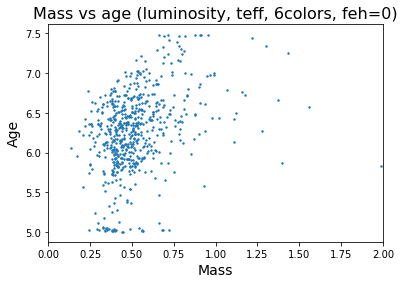

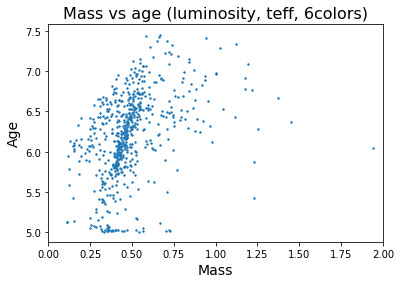

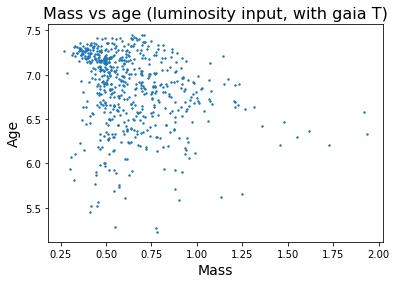

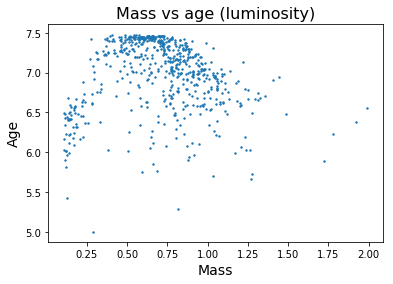

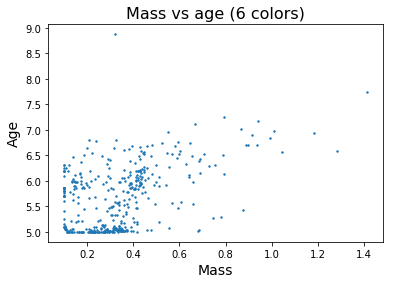

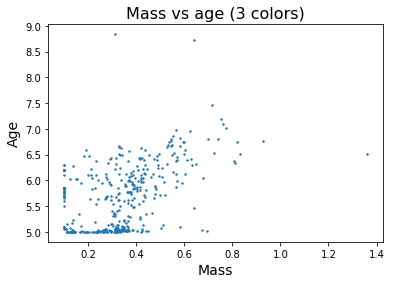

In [56]:
plt.figure()
plt.title("Mass vs age (luminosity, teff, 6colors, feh=0)")
plt.xlabel("Mass")
plt.ylabel("Age")
#plt.ylim(6,-4)
plt.xlim(0, 2)
plt.scatter(data_lum_teff_cols_feh0['mass'],data_lum_teff_cols_feh0['age'], s = 2)
plt.show()


plt.figure()
plt.title("Mass vs age (luminosity, teff, 6colors)")
plt.xlabel("Mass")
plt.ylabel("Age")
plt.xlim(0, 2)
#plt.ylim(6,-4)
#plt.xlim(5500,2000)
plt.scatter(data_lum_teff_cols['mass'],data_lum_teff_cols['age'], s = 2)
plt.show()








plt.figure()
plt.title("Mass vs age (luminosity input, with gaia T)")
plt.xlabel("Mass")
plt.ylabel("Age")
#plt.ylim(6,-4)
#plt.xlim(5500,2000)
plt.scatter(data_lum_gaia_temps['mass'],data_lum_gaia_temps['age'], s = 2)
plt.show()



plt.figure()
plt.title("Mass vs age (luminosity)")
plt.xlabel("Mass")
plt.ylabel("Age")
#plt.ylim(6,-4)
#plt.xlim(5500,2000)
plt.scatter(data_lum['mass'],data_lum['age'], s = 2)
plt.show()



plt.figure()
plt.title("Mass vs age (6 colors)")
plt.xlabel("Mass")
plt.ylabel("Age")
#plt.ylim(6,-4)
#plt.xlim(5500,2000)
plt.scatter(data['mass'],data['age'], s = 2)
plt.show()

plt.figure()
plt.title("Mass vs age (3 colors)")
plt.xlabel("Mass")
plt.ylabel("Age")
#plt.ylim(6,-4)
#plt.xlim(5500,2000)
#plt.scatter(data['mass'],data['age'], s = 1)
plt.scatter(data_old['mass'],data_old['age'], s = 2)
plt.show()




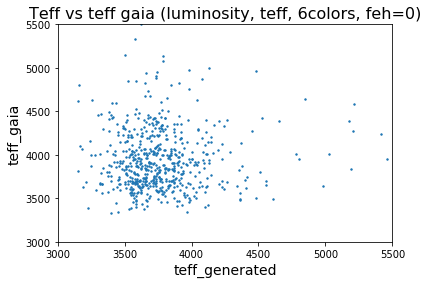

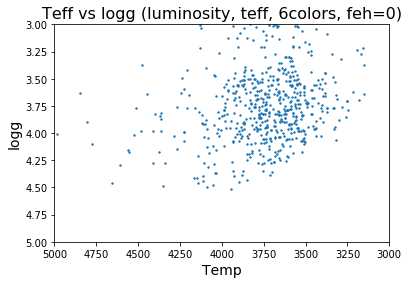

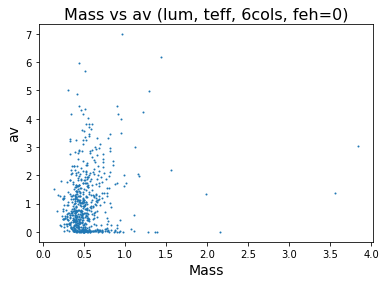

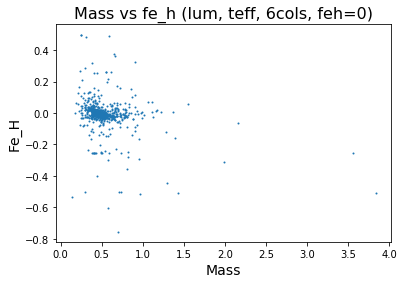

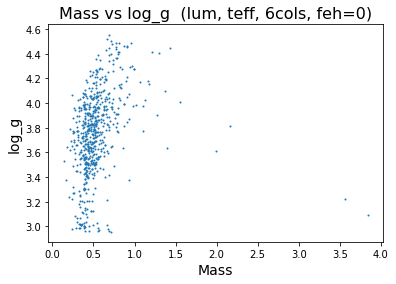

In [62]:
plt.figure()
plt.title("Teff vs teff gaia (luminosity, teff, 6colors, feh=0)")
plt.xlabel("teff_generated")
plt.ylabel("teff_gaia")
plt.ylim(3000,5500)
plt.xlim(3000,5500)

plt.scatter(data_lum_teff_cols_feh0['teff'],teff, s = 2)
plt.show()




plt.figure()
plt.title("Teff vs logg (luminosity, teff, 6colors, feh=0)")
plt.xlabel("Temp")
plt.ylabel("logg")
plt.ylim(5,3)
plt.xlim(5000,3000)
plt.scatter(data_lum_teff_cols_feh0['teff'],data_lum_teff_cols_feh0['log_g'], s = 2)
plt.show()


plt.figure()
plt.title("Mass vs av (lum, teff, 6cols, feh=0)")
plt.xlabel("Mass")
plt.ylabel("av")
#plt.xlim(0,.7)
#plt.ylim(6,-2)
plt.scatter(data_lum_teff_cols_feh0['mass'],data_lum_teff_cols_feh0['av'], s = 1)


plt.show()
plt.figure()
plt.title("Mass vs fe_h (lum, teff, 6cols, feh=0)")
plt.xlabel("Mass")
plt.ylabel("Fe_H")
plt.scatter(data_lum_teff_cols_feh0['mass'],data_lum_teff_cols_feh0['fe_h'], s = 1)
plt.savefig("mass_vs_feh.png")
plt.show()


plt.figure()
plt.title("Mass vs log_g  (lum, teff, 6cols, feh=0)")
plt.xlabel("Mass")
plt.ylabel("log_g")
plt.scatter(data_lum_teff_cols_feh0['mass'],data_lum_teff_cols_feh0['log_g'], s = 1)
plt.savefig("mass_vs_logg.png")
plt.show()

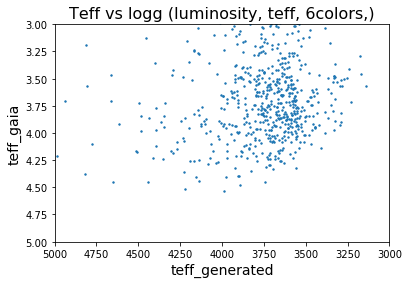

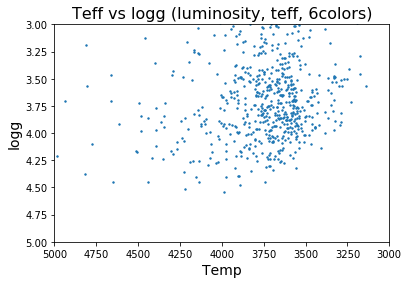

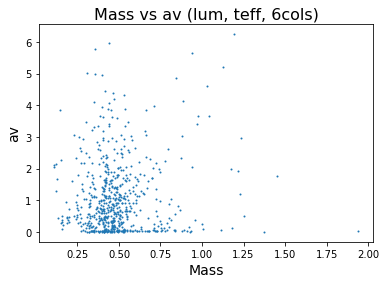

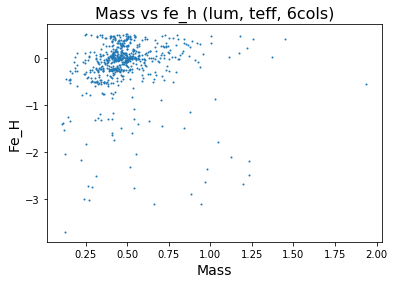

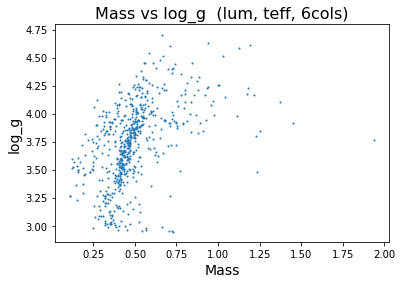

In [63]:
plt.figure()
plt.title("Teff vs logg (luminosity, teff, 6colors,)")
plt.xlabel("teff_generated")
plt.ylabel("teff_gaia")
plt.ylim(5,3)
plt.xlim(5000,3000)
plt.scatter(data_lum_teff_cols['teff'],data_lum_teff_cols['log_g'], s = 2)
plt.show()


plt.figure()
plt.title("Teff vs logg (luminosity, teff, 6colors)")
plt.xlabel("Temp")
plt.ylabel("logg")
plt.ylim(5,3)
plt.xlim(5000,3000)
plt.scatter(data_lum_teff_cols['teff'],data_lum_teff_cols['log_g'], s = 2)
plt.show()


plt.figure()
plt.title("Mass vs av (lum, teff, 6cols)")
plt.xlabel("Mass")
plt.ylabel("av")
#plt.xlim(0,.7)
#plt.ylim(6,-2)
plt.scatter(data_lum_teff_cols['mass'],data_lum_teff_cols['av'], s = 1)
plt.savefig("mass_vs_av.png")
plt.show()
plt.figure()
plt.title("Mass vs fe_h (lum, teff, 6cols)")
plt.xlabel("Mass")
plt.ylabel("Fe_H")
plt.scatter(data_lum_teff_cols['mass'],data_lum_teff_cols['fe_h'], s = 1)
plt.savefig("mass_vs_feh.png")
plt.show()


plt.figure()
plt.title("Mass vs log_g  (lum, teff, 6cols)")
plt.xlabel("Mass")
plt.ylabel("log_g")
plt.scatter(data_lum_teff_cols['mass'],data_lum_teff_cols['log_g'], s = 1)
plt.savefig("mass_vs_logg.png")
plt.show()

# Everything that isn't mass vs age, luminosity

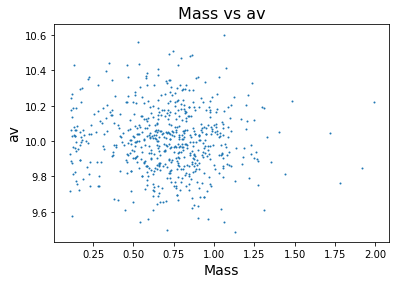

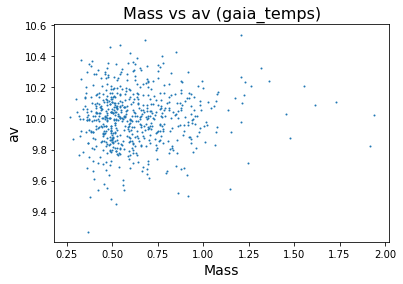

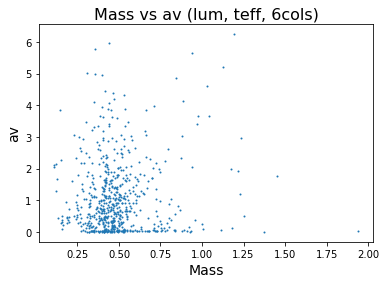

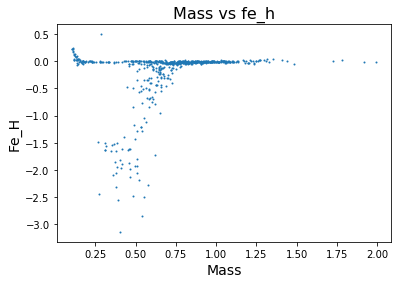

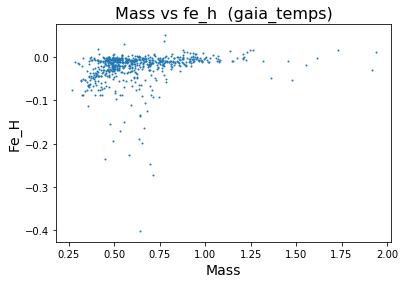

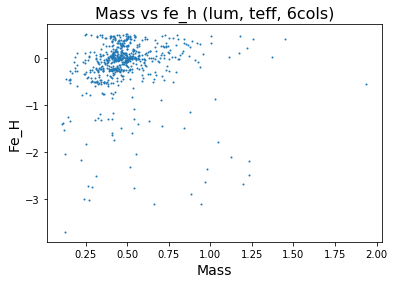

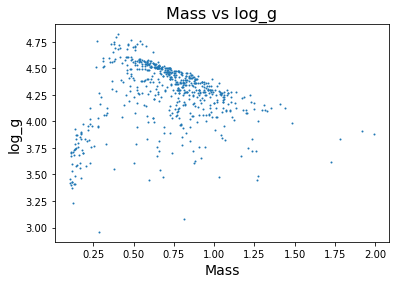

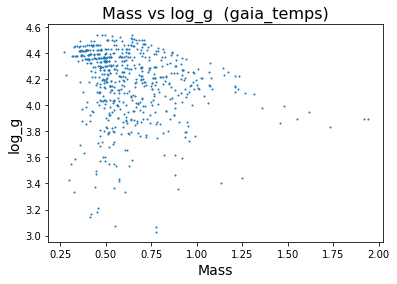

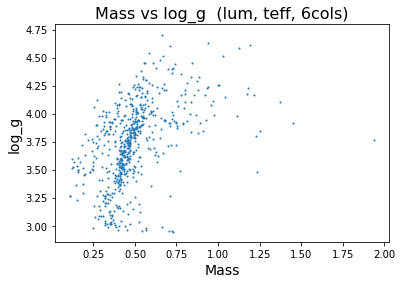

In [46]:
%matplotlib inline
'''plt.figure()
plt.title("T_eff vs K_abs")
plt.xlabel("Teff")
plt.ylabel("K_abs")
#plt.xlim(5500,2000)
plt.ylim(6,-4)
plt.scatter(data_lum['teff'], (K_app_PMSMD[:400]+Dist_mod_PMSMD[:400]), s = 1)
plt.show()

plt.figure()
plt.title("Mass vs K_abs")
plt.xlabel("Mass")
plt.ylabel("K_abs")
#plt.xlim(0,.7)
plt.ylim(6,-2)
plt.scatter(data_lum['mass'],(K_app_PMSMD[:400]+Dist_mod_PMSMD[:400]), s = 1)
plt.show()'''


plt.figure()
plt.title("Mass vs av")
plt.xlabel("Mass")
plt.ylabel("av")
#plt.xlim(0,.7)
#plt.ylim(6,-2)
plt.scatter(data_lum['mass'],data_lum['av'], s = 1)
plt.savefig("mass_vs_av.png")
plt.show()


plt.figure()
plt.title("Mass vs av (gaia_temps)")
plt.xlabel("Mass")
plt.ylabel("av")
#plt.xlim(0,.7)
#plt.ylim(6,-2)
plt.scatter(data_lum_gaia_temps['mass'],data_lum_gaia_temps['av'], s = 1)
plt.savefig("mass_vs_av.png")
plt.show()



plt.figure()
plt.title("Mass vs av (lum, teff, 6cols)")
plt.xlabel("Mass")
plt.ylabel("av")
#plt.xlim(0,.7)
#plt.ylim(6,-2)
plt.scatter(data_lum_teff_cols['mass'],data_lum_teff_cols['av'], s = 1)
plt.savefig("mass_vs_av.png")
plt.show()



plt.figure()
plt.title("Mass vs fe_h")
plt.xlabel("Mass")
plt.ylabel("Fe_H")
plt.scatter(data_lum['mass'],data_lum['fe_h'], s = 1)
plt.savefig("mass_vs_feh.png")
plt.show()



plt.figure()
plt.title("Mass vs fe_h  (gaia_temps)")
plt.xlabel("Mass")
plt.ylabel("Fe_H")
plt.scatter(data_lum_gaia_temps['mass'],data_lum_gaia_temps['fe_h'], s = 1)
plt.savefig("mass_vs_feh.png")
plt.show()


plt.figure()
plt.title("Mass vs fe_h (lum, teff, 6cols)")
plt.xlabel("Mass")
plt.ylabel("Fe_H")
plt.scatter(data_lum_teff_cols['mass'],data_lum_teff_cols['fe_h'], s = 1)
plt.savefig("mass_vs_feh.png")
plt.show()



plt.figure()
plt.title("Mass vs log_g")
plt.xlabel("Mass")
plt.ylabel("log_g")
plt.scatter(data_lum['mass'],data_lum['log_g'], s = 1)
plt.savefig("mass_vs_logg.png")
plt.show()


plt.figure()
plt.title("Mass vs log_g  (gaia_temps)")
plt.xlabel("Mass")
plt.ylabel("log_g")
plt.scatter(data_lum_gaia_temps['mass'],data_lum_gaia_temps['log_g'], s = 1)
plt.savefig("mass_vs_logg.png")
plt.show()



plt.figure()
plt.title("Mass vs log_g  (lum, teff, 6cols)")
plt.xlabel("Mass")
plt.ylabel("log_g")
plt.scatter(data_lum_teff_cols['mass'],data_lum_teff_cols['log_g'], s = 1)
plt.savefig("mass_vs_logg.png")
plt.show()

# Not mass vs age, 6 colors

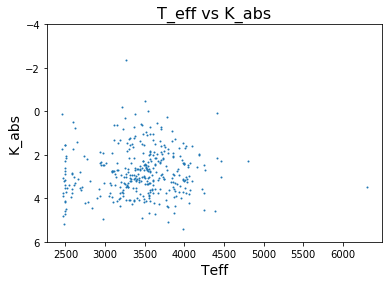

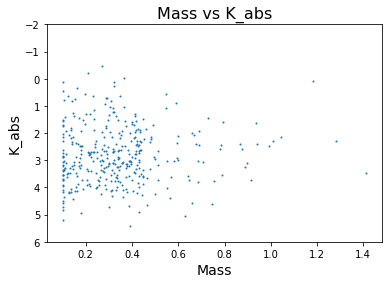

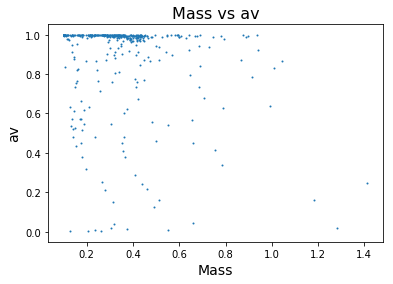

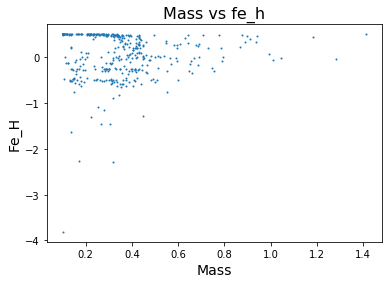

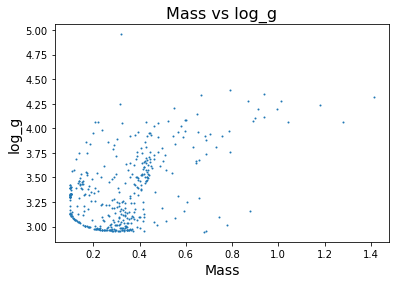

In [79]:
plt.figure()
plt.title("T_eff vs K_abs")
plt.xlabel("Teff")
plt.ylabel("K_abs")
#plt.xlim(5500,2000)
plt.ylim(6,-4)
plt.scatter(data['teff'], (K_app_PMSMD[:400]+Dist_mod_PMSMD[:400]), s = 1)
plt.show()

plt.figure()
plt.title("Mass vs K_abs")
plt.xlabel("Mass")
plt.ylabel("K_abs")
#plt.xlim(0,.7)
plt.ylim(6,-2)
plt.scatter(data['mass'],(K_app_PMSMD[:400]+Dist_mod_PMSMD[:400]), s = 1)
plt.show()


plt.figure()
plt.title("Mass vs av")
plt.xlabel("Mass")
plt.ylabel("av")
#plt.xlim(0,.7)
#plt.ylim(6,-2)
plt.scatter(data['mass'],data['av'], s = 1)
plt.show()

plt.figure()
plt.title("Mass vs fe_h")
plt.xlabel("Mass")
plt.ylabel("Fe_H")
plt.scatter(data['mass'],data['fe_h'], s = 1)
plt.show()

plt.figure()
plt.title("Mass vs log_g")
plt.xlabel("Mass")
plt.ylabel("log_g")
plt.scatter(data['mass'],data['log_g'], s = 1)
plt.show()

# 3 colors

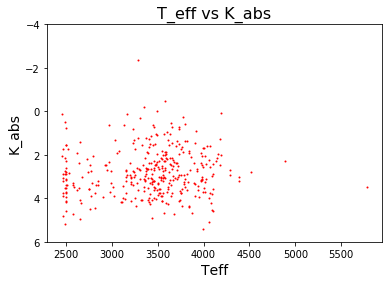

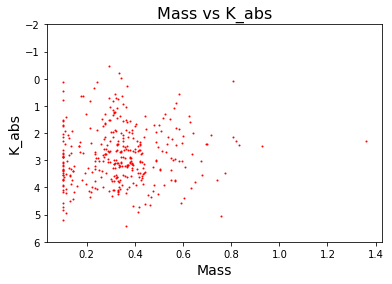

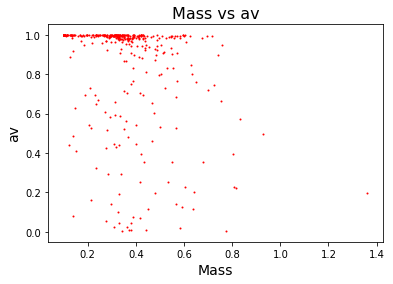

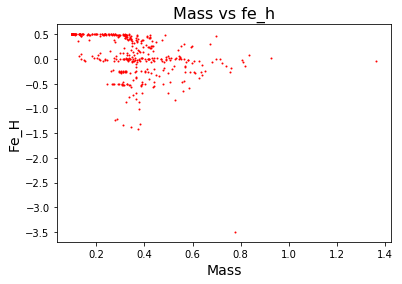

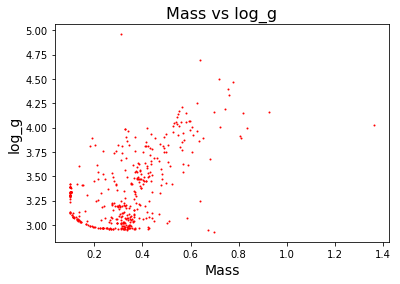

In [80]:
plt.figure()
plt.title("T_eff vs K_abs")
plt.xlabel("Teff")
plt.ylabel("K_abs")
#plt.xlim(5500,2000)
plt.ylim(6,-4)
plt.scatter(data_old['teff'], (K_app_PMSMD[:400]+Dist_mod_PMSMD[:400]), s = 1, c='red')
plt.show()

plt.figure()
plt.title("Mass vs K_abs")
plt.xlabel("Mass")
plt.ylabel("K_abs")
#plt.xlim(0,.7)
plt.ylim(6,-2)
plt.scatter(data_old['mass'],(K_app_PMSMD[:400]+Dist_mod_PMSMD[:400]), s = 1, c='red')
plt.show()


plt.figure()
plt.title("Mass vs av")
plt.xlabel("Mass")
plt.ylabel("av")
#plt.xlim(0,.7)
#plt.ylim(6,-2)
plt.scatter(data_old['mass'],data_old['av'], s = 1, c='red')
plt.show()

plt.figure()
plt.title("Mass vs fe_h")
plt.xlabel("Mass")
plt.ylabel("Fe_H")
plt.scatter(data_old['mass'],data_old['fe_h'], s = 1, c='red')
plt.show()

plt.figure()
plt.title("Mass vs log_g")
plt.xlabel("Mass")
plt.ylabel("log_g")
plt.scatter(data_old['mass'],data_old['log_g'], s = 1, c='red')
plt.show()

# The dumpster

In [57]:
#importing the pickle file
with open("parsecgrid.pickle", 'rb') as file:
    data = pickle.load(file, encoding ='latin1')
data = data[0]

AGE = np.array(data[0])
MINI = np.array(data[1])
MASS = np.array(data[2])
TEFF = np.array(data[3])
LOGG = np.array(data[4])
GMAG = np.array(data[5])
GB = np.array(data[6])
GR = np.array(data[7])
BV = np.array(data[8])
JMAG = np.array(data[9])
HMAG = np.array(data[10])
KMAG = np.array(data[11])
GBR = np.array(data[12])
LL = np.array(data[13])

In [58]:
#widdling down the data, see Dr. Kounkels .pro file. I've copied what she's doing
a=np.where(AGE < 4e7)[0]
b=np.where(MINI < 20)[0]
JMK = (JMAG-KMAG)[b,:]
JMK = JMK[:,a]
K_abs_model = KMAG[b,:]
K_abs_model = K_abs_model[:,a]
x=J_minus_K_PMSMD
teff = []
delta_list = []
TEFF_trimed = TEFF[b,:]
TEFF_trimed = TEFF_trimed[:,a]
LOGG_trimmed = LOGG[b,:]
LOGG_trimmed = LOGG_trimmed[:,a]
print(np.shape(JMAG))
print(np.shape(JMK))

(1500, 300)
(1174, 181)


In [59]:
masses = np.arange(0.1,1,.1) 
ages = [1e6, 5e6,1e7,5e7,1e8,5e8,1e9]
def find_nearest_index(array, values):
    idx = []
    for x in range(np.size(values)):
        idx.append((np.abs(array - values[x])).argmin())
    return np.array(idx)

mass_idx = find_nearest_index(MINI, masses)
ages_idx = find_nearest_index(AGE, ages)

TEFF_T = np.transpose(TEFF)
KMAG_T = np.transpose(KMAG)
MASS_T = np.transpose(MASS)
GBR_T = np.transpose(GBR)

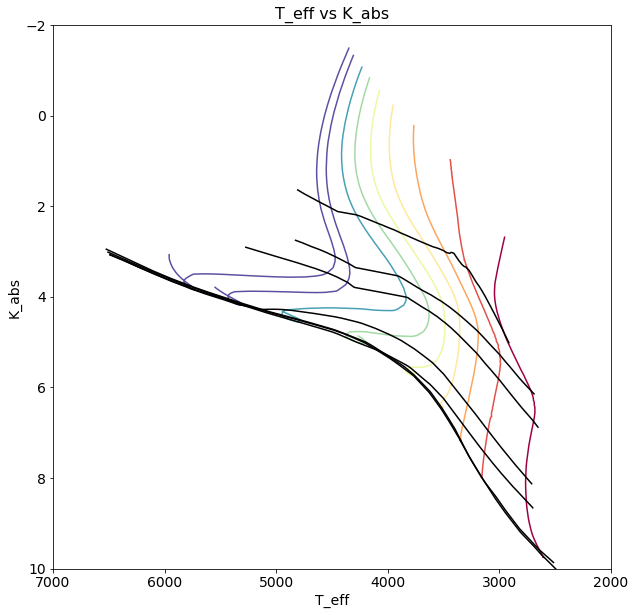

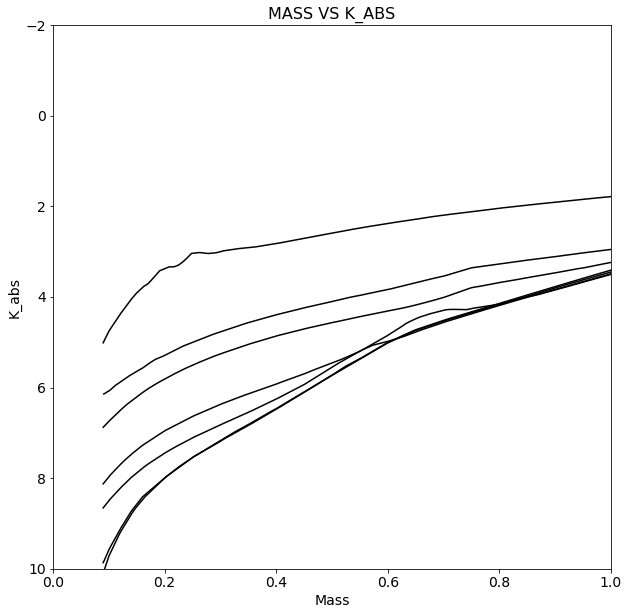

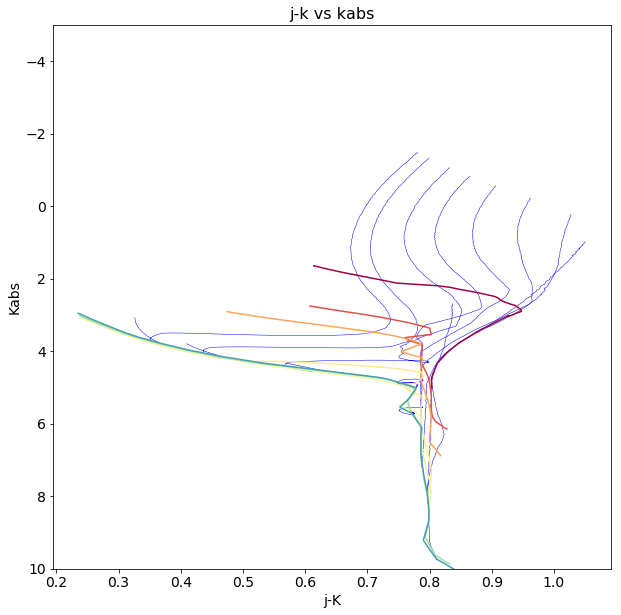

In [64]:
plt.figure()
plt.title("T_eff vs K_abs")
plt.xlabel("T_eff")
plt.ylabel("K_abs")
plt.xlim(7000,2000)
plt.ylim(10,-2)
cut = 550

for x in range(np.size(mass_idx)):
    plt.plot(TEFF[mass_idx[x]],KMAG[mass_idx[x]],c = cmap(x/float(7)))
for x in range(np.size(ages_idx)):
    plt.plot(TEFF_T[ages_idx[x]][:cut],KMAG_T[ages_idx[x]][:cut],c = 'black')
plt.show()


plt.figure()
plt.title("MASS VS K_ABS")
plt.xlabel("Mass")
plt.ylabel("K_abs")
plt.xlim(0,1)
plt.ylim(10,-2)
for x in range(np.size(ages_idx)):
    plt.plot(MASS_T[ages_idx[x]][:cut],KMAG_T[ages_idx[x]][:cut],c = 'black')
plt.show()


plt.figure()
plt.title("j-k vs kabs")
plt.xlabel("j-K")
plt.ylabel("Kabs")
plt.ylim(10,-5)
for x in range(np.size(mass_idx)):
    plt.plot((JMAG-KMAG)[mass_idx[x]],KMAG[mass_idx[x]],c = 'blue', lw=0.5)
for x in range(np.size(ages_idx)):
    plt.plot((JMAG-KMAG).T[ages_idx[x]][:cut],KMAG_T[ages_idx[x]][:cut],c = cmap(x/float(7)))
plt.show()

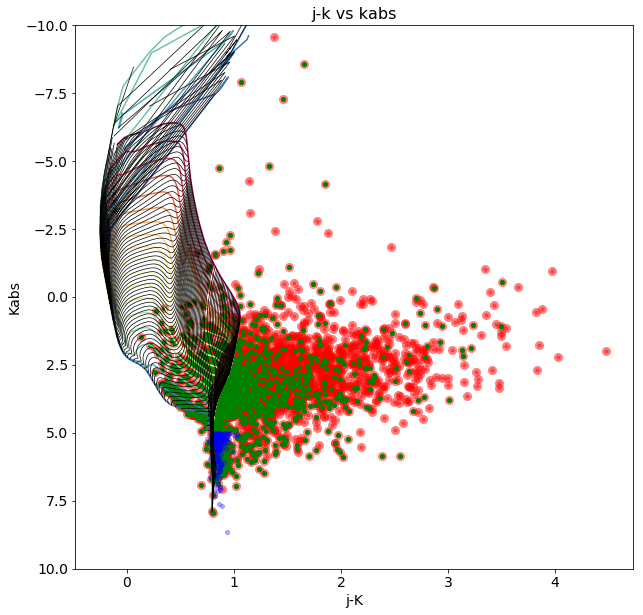

In [69]:
plt.figure()
plt.title("j-k vs kabs")
plt.xlabel("j-K")
plt.ylabel("Kabs")
plt.ylim(10,-10)
for x in range(math.ceil(len(JMK.T)/10)): #for ages
    plt.plot(JMK.T[x*10], K_abs_model.T[x*10], c = cmap(x/float(math.ceil(len(JMK.T)/10))))
for x in range(math.ceil(len(JMK)/10)): #for Mini
    plt.plot(JMK[x*10], K_abs_model[x*10], c = 'black', lw=0.7)

'''These points fit horribly! I've sent the data to Dr. Kounkel for a double check.
FOLLOW UP: She said the isochrones are a bad fit for this data.
She is going to get us new isochrones, in the mean time use https://arxiv.org/pdf/1805.04649.pdf
page 9. (t grid’s MG by +0.2 mag, and [GB − GR] by +0.15 mag) to get something semi-functional and to
test out routines'''
#The PMS stars BEFORE the disk filter
for x in range(len(J_minus_K_PMSM)):
    plt.scatter(J_minus_K_PMSM[x],K_abs_PMSM[x], lw = 5, c = 'red',alpha=0.5)  
    

#The PMS stars AFTER the disk filter
for x in range(len(J_minus_K_PMSMD)):
    plt.scatter(J_minus_K_PMSMD[x],K_abs_PMSMD[x], lw = 1, c = 'green')  


####These points fit well!            
J_minus_K_MS = J_abs_MS-K_abs_MS
for x in range(200):
    plt.scatter((J_minus_K_MS)[x*3],K_abs_MS[x*3], lw = 1, c = 'blue',alpha=0.3)

In [67]:
#we have a close age, and a close mass. Use this to infer teff and logg
TEFF_func = interpolate.interp2d(AGE[a], MINI[b], TEFF_trimed)#, kind='cubic')
LOGG_func = interpolate.interp2d(AGE[a], MINI[b], LOGG_trimmed)#, kind='cubic')


#for i in range(len(J_minus_K_PMS)):
for i in range(5):
    if(np.isfinite(J_minus_K_PMS[i]) & np.isfinite(K_abs_PMS[i])):
        offx = 0.001
        offy = 0.001
        where = np.where(K_abs_model<-100000000)       
        while(len(where[0])==0):
            where = np.where((abs(JMK-J_minus_K_PMS[i])<offx) & (abs(K_abs_model - K_abs_PMS[i])<offy))
            offx = offx*2
            offy = offy*2
            
        mass_avg = np.mean(MINI[where[0]])
        age_avg = np.mean(AGE[where[1]])   
        T_label = TEFF_func(age_avg, mass_avg)
        #logg_label = LOGG_func(mass_avg, age_avg)
        print(T_label)
        best_JMK = JMK[where[0][0]][where[1][0]]
        best_K_abs = K_abs_model[where[0][0]][where[1][0]]
        delta_j_minus_k = (best_JMK - J_minus_K_PMS[i])/J_minus_K_err_PMS[i]
        delta_K_abs =(best_K_abs - K_abs_PMS[i])/K_abs_err_PMS[i]
        delta = (delta_j_minus_k**2 + delta_K_abs**2)**(1/2)
        delta_list.append(delta)
        teff.append(T_label)
    else:
        delta_list.append(-1)
        teff.append("ERR")

[nan]
[nan]
[nan]
[nan]
[nan]


In [178]:
#####Everything below this is garbage/test stuff



col1 = fits.Column(name='J_minus_K_PMS', format='20A', array=J_minus_K_PMS)
col2 = fits.Column(name='K_abs_PMS', format='20A', array=K_abs_PMS)
col3 = fits.Column(name='J_minus_K_MS', format='20A', array=J_minus_K_MS)
col4 = fits.Column(name='K_abs_MS', format='20A', array=K_abs_MS)
cols = fits.ColDefs([col1, col2, col3, col4])
hdu_export = fits.BinTableHDU.from_columns(cols)
hdu_export.writeto('K_abs_and_j-k.fits')

In [26]:
#Using this to get a memeber_index
export = []
for x,z in enumerate(member_overlap):  
    for i, j in enumerate(PMS_IDs):
        if j == z:
            export.append(i)
            
np.savetxt('member_index.txt', export, fmt='%i', delimiter=',')   # X is an array

In [172]:
file = 'MS_Labels_w_source.fits'
test_hdu = fits.open(file)
#print(test_hdu[1].header)

In [16]:
def find_indices(ID1,ID2,ID_min):
    ID2_index = []
    ID1_index = []
    index = 0
    for x in range(len(ID2)):
        if ID2[x] == ID1[index]:
            ID1_index.append(index)
            ID2_index.append(x)
            index += 1
        elif ID2[x] > ID1[index]:
            index += 1
        if (x+1>=ID_min):
            return ID1_index, ID2_index
    return ID1_index, ID2_index



def make_JmK_vs_MK(xaxis, yaxis, title, xtitle, ytitle):
    plt.title(title)
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)
    plt.ylim(10,-15)
    plt.xlim(-2.5,5)
    plt.scatter(xaxis, yaxis, s=0.01)
    plt.show()

In [35]:
#demonstrating the sort function works, but it doesn't entirely. Last index
test1 = [1,2,4,5,6,8,10,11,14]
test2 = [1,3,4,5,6,7,8,10,11,12,14,15]
testlen = min(len(test1), len(test2))
print(testlen)
test1 = np.sort(test1)
test2 = np.sort(test2)
test_index1, test_index2 = find_indices(test1,test2,testlen)

new1 = test1[test_index1]
new2 = test2[test_index2]

print(new1)
print(new2)


9
[ 1  4  5  6  8 10 11]
[ 1  4  5  6  8 10 11]


2014-08-10
XTENSION= 'IMAGE   '           / IMAGE extension                                BITPIX  =                  -32 / Number of bits per data pixel                  NAXIS   =                    1 / Number of data axes                            NAXIS1  =                 8575 /                                                PCOUNT  =                    0 / No Group Parameters                            GCOUNT  =                    1 / One Data Group                                 CRVAL1  =        4.17900000000 /                                                CDELT1  =    6.00000000000E-06 /                                                CRPIX1  =                    1 /                                                CTYPE1  = 'LOG-LINEAR'         /                                                DC-FLAG =                    1 /                                                BUNIT   = 'Flux (10^-17 erg/s/cm^2/Ang)' /                                      END                          

(15960, 16000)

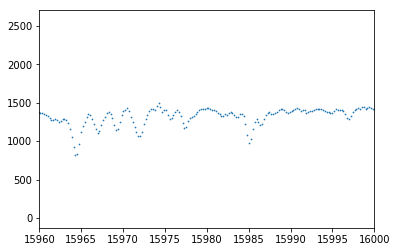

In [5]:
#A random fits file from Dr. Covey's server
random = "apStarC-r5-2M21432388+4209512.fits"
hdu = fits.open(random)


'''hdu[0].header['NAME'], where you can pull anything 
named NAME from the header file. See link (in slack) for list of NAME's. 
 https://data.sdss.org/datamodel/files/APOGEE_REDUX/APRED_VERS
/APSTAR_VERS/TELESCOPE/LOCATION_ID/apStar.html'''
date = hdu[0].header['DATE']
print(date)

#the header, showing starting wavelength and other
fluxhead = hdu[1].header 
print(fluxhead)
#the data
flux = hdu[1].data
print("\n", flux)

#relevant information (starting wavelength, and conversion) found in header
wavelength = 10.**(4.179+6e-6*np.arange(0,len(flux),1))

plt.scatter(wavelength,flux,s=0.5)
plt.xlim(15960,16000)